## Part 2: Polynomial Regression

We discussed in the previous part about how Linear Regression can be used to estimate a relationship between some variables (also known as predictors, regressors, or independent variables) and some target (also known as response, regressed/ant, or dependent variables). We used the Boston dataset and eventually got an accuracy of ~74%. We also discussed how we can add more variables by creating new features. We will see how in this article.

### Imports and loading data

Everything here should look familiar, all these were taken from the previous article.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.datasets import load_boston

In [2]:
boston_data = load_boston()

data = pd.DataFrame(data=boston_data["data"], columns=boston_data["feature_names"])
Y = pd.DataFrame(boston_data["target"], columns=["Price in $1000s"])

### Polynomial Regression, 1 variable with 2 degrees

For a change, let's use another variable this time: LSTAT  (*% lower status of the population*). First we will perform a simple linear regression to see how this variable fares in predicting the mean house value. Then, we can manually compute its squared value and assign it to a new column in the DataFrame, LSTAT2 and use that for a polynomial regression (in essence the same as a multiple regression).

#### Linear Regression with LSTAT

In [3]:
# Remember that for 1 variable we have to reshape it
X = data["LSTAT"].values.reshape((-1,1))

baseline_model = LinearRegression()
baseline_model.fit(X,Y)

print("The model explains {:.2f}% of the average price.".format(baseline_model.score(X,Y)*100))

The model explains 54.41% of the average price.


Much better than number of rooms! We leave plotting this model as an exercise, and move on to Polynomial Regression.

#### Polynomial Regression

Polynomial Regression with sklearn is a little more involved so we will discuss it a bit later. For now we will make the squared LSTAT manually:

In [4]:
# store the squared values in a new column in the DataFrame
data["LSTAT2"] = data['LSTAT'] ** 2

In [5]:
# Now as X we will pick these two variables
X = data[["LSTAT", "LSTAT2"]]

In [6]:
# Let's take a look at X
X.head()

,LSTAT,LSTAT2
0,4.98,24.8004
1,9.14,83.5396
2,4.03,16.2409
3,2.94,8.6436
4,5.33,28.4089


In [7]:
# Everything here should also look familiar
polynomial_model = LinearRegression()
polynomial_model.fit(X,Y)

print("The model explains {:.2f}% of the average price.".format(polynomial_model.score(X,Y)*100))

The model explains 64.07% of the average price.


An absolute improvement of 10%. Not bad for a couple extra lines of code!

### Visualizing the polynomial model

#### Calculating the predictions

We will again use linearly spaced data

In [8]:
a = polynomial_model.coef_
b = polynomial_model.intercept_

# note that coef is an array of values, not just 1 value
a

array([[-2.3328211 ,  0.04354689]])

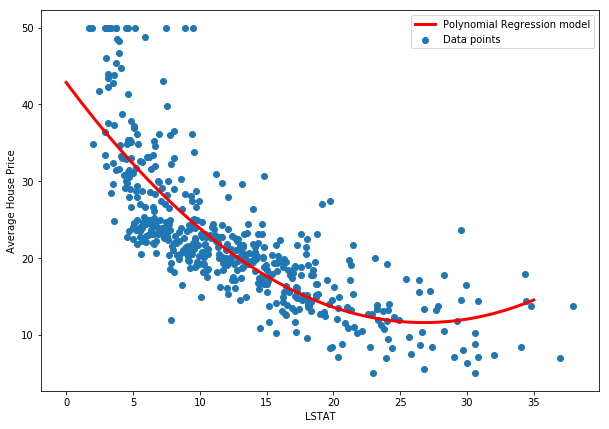

In [9]:
plt.figure(figsize=(10,7))

# We do not need to plot against LSTAT2, just LSTAT
plt.scatter(data["LSTAT"],Y, label="Data points")

# Now we have 2 variables, and the second 
# is the squared version of the first
linearly_spaced_data_X1 = np.linspace(0, 35, 100)
linearly_spaced_data_X2 = linearly_spaced_data_X1 ** 2

# The @ symbol performs matrix multiplication
# it is a shortcut for multiplying each 
# coefficient with the respective X column (variable)
linearly_spaced_data_Y = a @ (linearly_spaced_data_X1, linearly_spaced_data_X2) + b

plt.plot(linearly_spaced_data_X1, linearly_spaced_data_Y.reshape((-1,)),
         color='red', lw=3, label="Polynomial Regression model")

# Some plotting parameters to make the plot look nicer
plt.xlabel("LSTAT")
plt.ylabel("Average House Price")
plt.legend();

We can see that this model seems to capture the true relationship much better. Now let's try with all the variables.

### Polynomial Regression, all variables, degree-2 polynomials

Here we will also use demonstrate how to use sklearn's Polynomial Features.

In [10]:
from sklearn.preprocessing import PolynomialFeatures

In [11]:
features = PolynomialFeatures(degree=2)

For creating features we create a `PolynomialFeatures` instance, specify a degree, and instead of fitting, we `fit_transform` (don't let the name confuse you, it doesn't actually do any sort of fitting). We save the results as our new X:

In [12]:
X = features.fit_transform(data)

In [13]:
X.shape

(506, 120)

`X.shape` shows us that we have the same number of samples, 506, but now we have 136 columns instead of 2\*13=26!  So what happened? `PolynomialFeatures` creates more than just the squares. It also creates interaction terms. For example, let's say we had two features, X and Z. `PolynomialFeatures` creates X² and Z² but it also creates 1 (this is for the intercept) and X\*Z, and it also returns X and Z themselves. From the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html):

    if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

These interaction terms usually increase model performance significantly (even if they don't have any relationship with Y, in which case they will just be dropped by the model by getting low coefficients). Let's create a new model and fit it:

In [14]:
# Everything here should also look familiar
full_polynomial_model = LinearRegression()
full_polynomial_model.fit(X,Y)

print("The model explains {:.2f}% of the average price.".format(full_polynomial_model.score(X,Y)*100))

The model explains 92.99% of the average price.


A whopping increase in performance!

#### Visualization

We cannot clearly visualize this model. Here is a scatterplot and a regular line plot of the data:

In [15]:
a = full_polynomial_model.coef_
b = full_polynomial_model.intercept_

predictions = a @ X.T + b

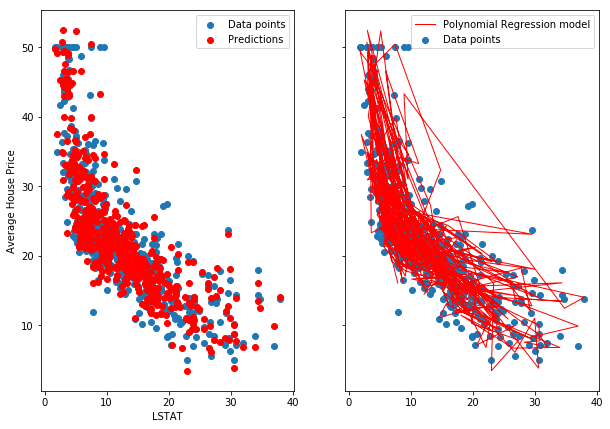

In [16]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,7), sharex=True, sharey=True)

# We do not need to plot against LSTAT2, just LSTAT
ax0.scatter(data["LSTAT"], Y, label="Data points")
ax1.scatter(data["LSTAT"], Y, label="Data points")

ax0.scatter(data["LSTAT"], predictions.reshape((506,)),
         color='red', lw=1, label="Predictions")

ax1.plot(data["LSTAT"], predictions.reshape((506,)),
         color='red', lw=1, label="Polynomial Regression model")


# Some plotting parameters to make the plot look nicer
ax0.set_xlabel("LSTAT")
ax0.set_ylabel("Average House Price")
ax0.legend();
ax1.legend();

And here is the incorrect approach. A correct approach would need some X-wise averaging, as suggested in the [SO answer](https://stackoverflow.com/a/12043751/6655150). The interested reader can perform that as an exercise.

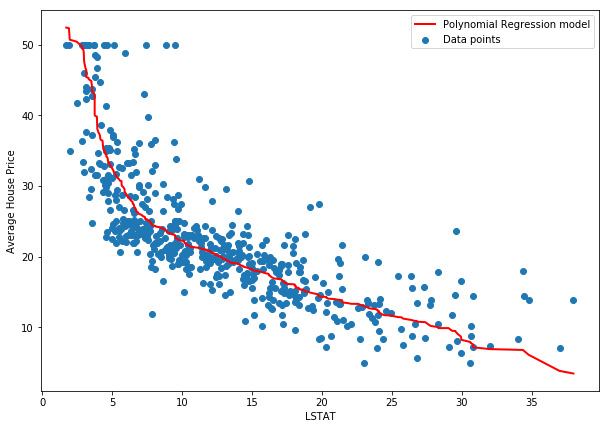

In [17]:
plt.figure(figsize=(10,7))

# We do not need to plot against LSTAT2, just LSTAT
plt.scatter(data["LSTAT"], Y, label="Data points")

# This is INCORRECT because it losses the real 
# mapping from data to prediction,a but I believe 
# it gives us a better picture of the model
plt.plot(sorted(data["LSTAT"]), sorted(predictions.reshape((506,)), reverse=True),
         color='red', lw=2, label="Polynomial Regression model")

# Some plotting parameters to make the plot look nicer
plt.xlabel("LSTAT")
plt.ylabel("Average House Price")
plt.legend();

### How many degrees?

It is easy to see that as we use polynomials of higher order (x³,x⁴, etc) the accuracy of our predictions will only rise. In fact, using 3rd degree polynomial features gets us to an R² of 1, or 100%. This is what is known as overfitting. The model does not find the relationship in the data, but instead "memorizes" the mapping from X to Y. This is bad because given a new data point, it will almost certainly predict it wrong. 

When modelling we usually split the data in two or three sets (training and testing, or training, validation, and testing). We train on one, evaluate on the other, and if we have a third we keep it till much later only for final evaluation purposes. We will get to these in other articles. For now, let's see how the 3-degree polynomial regression does:

In [18]:
features = PolynomialFeatures(degree=3)
X = features.fit_transform(data)

X.shape

(506, 680)

In [19]:
overfit_polynomial_model = LinearRegression()
overfit_polynomial_model.fit(X,Y)

print("The model explains {:.2f}% of the average price.".format(overfit_polynomial_model.score(X,Y)*100))

The model explains 100.00% of the average price.


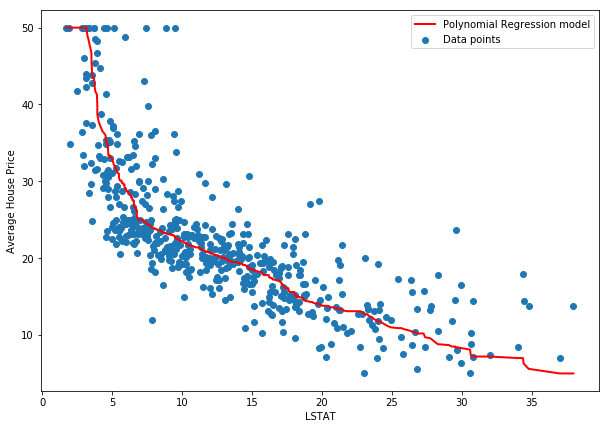

In [20]:
a = overfit_polynomial_model.coef_
b = overfit_polynomial_model.intercept_

predictions = a @ X.T + b

plt.figure(figsize=(10,7))

plt.scatter(data["LSTAT"], Y, label="Data points")

# again, the wrong method
plt.plot(sorted(data["LSTAT"]), sorted(predictions.reshape((506,)), reverse=True),
         color='red', lw=2, label="Polynomial Regression model")

plt.xlabel("LSTAT")
plt.ylabel("Average House Price")
plt.legend();

In this article we saw how to perform Polynomial Regression, we've demonstrated the use of sklearn's `PolynomialFeatures` class, and we introduced overfitting. In the next articles we will talk about stronger models, and some initial strategies for avoiding overfitting.